# Final project for "How to win a data science competition" Coursera course

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

import random
random.seed(0)

STEPS = 26

## Loading Data

### File descriptions
* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
* sample_submission.csv - a sample submission file in the correct format.
* items.csv - supplemental information about the items/products.
* item_categories.csv  - supplemental information about the items categories.
* shops.csv- supplemental information about the shops.

In [2]:
trainData = pd.read_csv('./sales_train.csv', parse_dates=['date'])

### Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [3]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [4]:
trainData.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


array([[<AxesSubplot:title={'center':'date'}>,
        <AxesSubplot:title={'center':'date_block_num'}>],
       [<AxesSubplot:title={'center':'shop_id'}>,
        <AxesSubplot:title={'center':'item_id'}>],
       [<AxesSubplot:title={'center':'item_price'}>,
        <AxesSubplot:title={'center':'item_cnt_day'}>]], dtype=object)

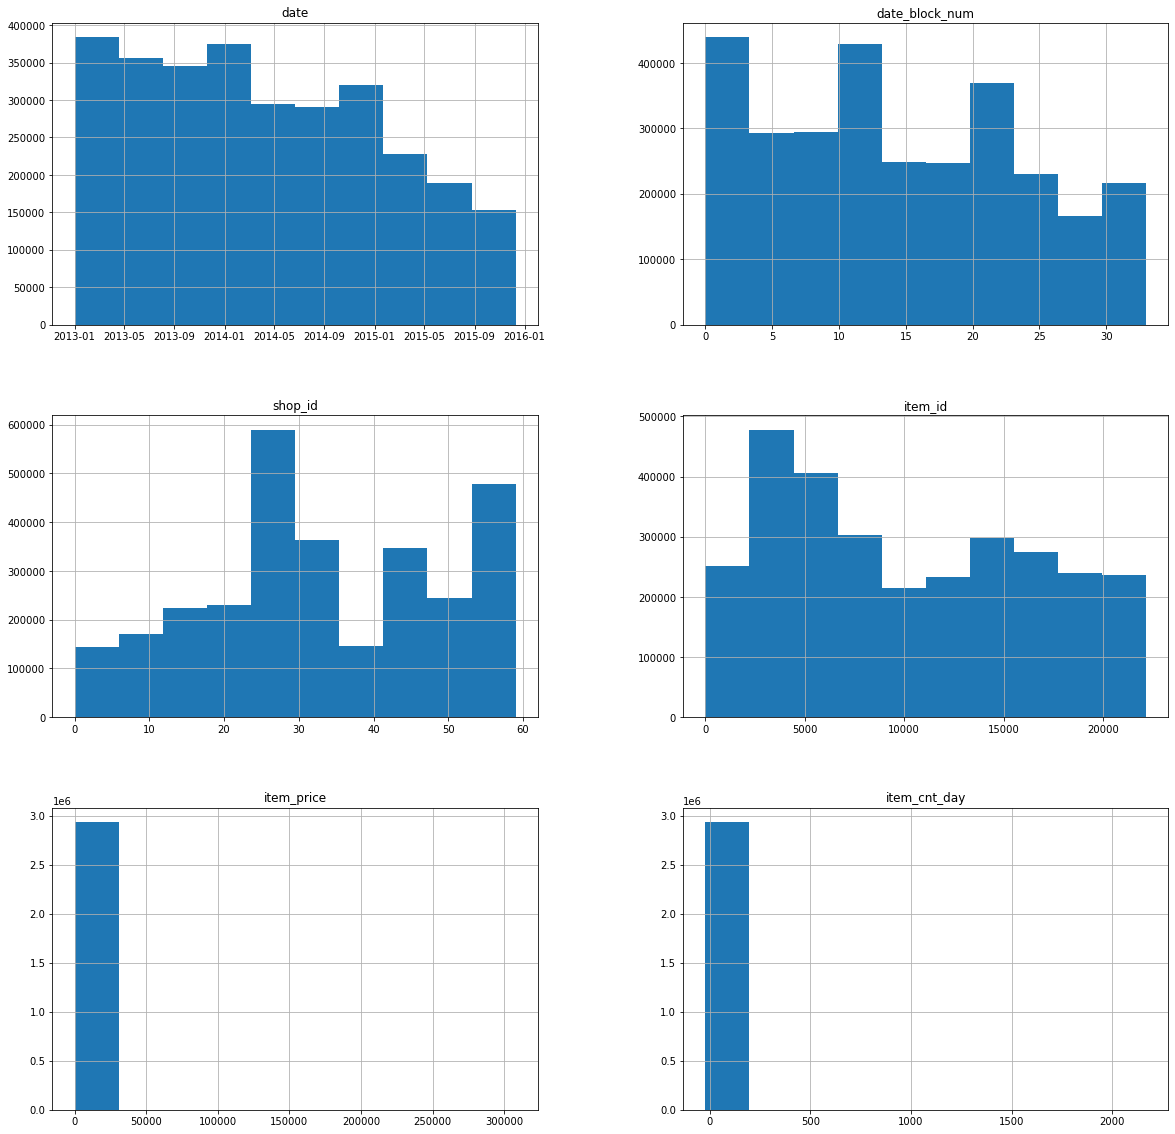

In [5]:
trainData.hist(figsize=(20, 20))

## Data Preprocessing

In [6]:
trainData = trainData[trainData['item_price']>0]
trainData = trainData[trainData['item_cnt_day']>0]

<AxesSubplot:xlabel='item_cnt_day', ylabel='Density'>

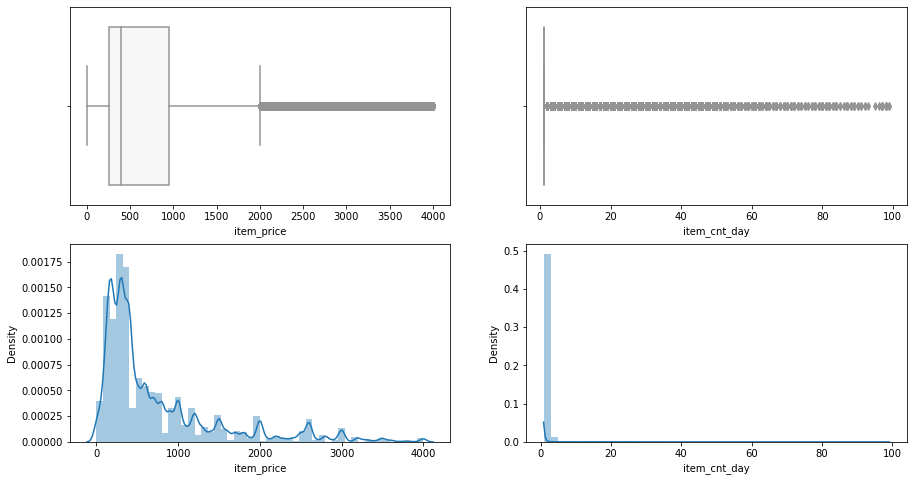

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
sns.boxplot(trainData['item_price'][trainData['item_price']<4000], palette='PRGn', ax = ax[0, 0])
sns.distplot(trainData['item_price'][trainData['item_price']<4000], ax = ax[1, 0])
sns.boxplot(trainData['item_cnt_day'][trainData['item_cnt_day']<100], palette='PRGn', ax = ax[0, 1])
sns.distplot(trainData['item_cnt_day'][trainData['item_cnt_day']<100], ax = ax[1, 1])

In [8]:
trainData['Month'] = trainData['date'].dt.to_period('M')
trainData

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,Month
0,2013-02-01,0,59,22154,999.00,1.0,2013-02
1,2013-03-01,0,25,2552,899.00,1.0,2013-03
3,2013-06-01,0,25,2554,1709.05,1.0,2013-06
4,2013-01-15,0,25,2555,1099.00,1.0,2013-01
5,2013-10-01,0,25,2564,349.00,1.0,2013-10
...,...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0,2015-10
2935845,2015-09-10,33,25,7460,299.00,1.0,2015-09
2935846,2015-10-14,33,25,7459,349.00,1.0,2015-10
2935847,2015-10-22,33,25,7440,299.00,1.0,2015-10


<AxesSubplot:xlabel='Month'>

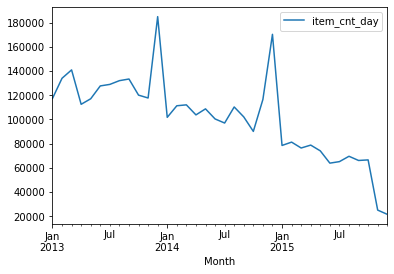

In [9]:
trainDataPerMonth = trainData.groupby(['Month']).agg({'item_cnt_day' : 'sum'})
trainDataPerMonth.reset_index(inplace=True)
trainDataPerMonth = trainDataPerMonth.set_index('Month')
trainDataPerMonth.plot()

## Forecasting

Train dates : 2013-01 --- 2015-02  (n=26)
Test dates  : 2015-03 --- 2015-12  (n=10)


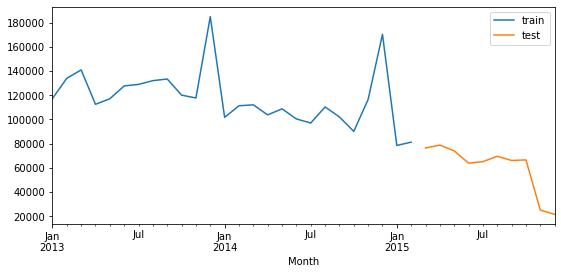

In [10]:
from sklearn.linear_model import LinearRegression

train = trainDataPerMonth[:STEPS]
test = trainDataPerMonth[STEPS:]


print(f"Train dates : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

fig, ax=plt.subplots(figsize=(9, 4))
train['item_cnt_day'].plot(ax=ax, label='train')
test['item_cnt_day'].plot(ax=ax, label='test')
ax.legend()


In [12]:
def test_stationarity(Y, X):
    timeseries = pd.Series(Y)
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    figure = {
        'data': [
            {'x': X, 'y': timeseries, 'type': 'line', 'name': 'Original'},
            {'x': X, 'y': rolmean, 'type': 'line', 'name': 'Rolling Mean'},
            {'x': X, 'y': rolstd, 'type': 'line', 'name': 'Rolling  Standard Deviation'},
        ],
        'layout': {'title': 'Rolling Mean & Standard Deviation',
                   'legend_orientation': "h"}
    }

    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['\nCritical Value (%s)' % key] = value
    return figure, dfoutput.to_dict()


In [ ]:
test_stationarity(train.Y, X)